Columns in the CSV file: ['0', 'S.No.', 'Commodity', '2018-2019', '2019– 2020', '2020– 2021', '2021– 2022', '2022– 2023(P) (Apr.-Sept.)']
Number of commodities with complete data: 23
Shape of X: (19, 3, 5), Shape of y: (19, 10)
Shape of X_train: (15, 3, 5), Shape of X_test: (4, 3, 5)
Epoch 1/100
1/1 [==============================] - 7s 7s/step - loss: 0.1804 - val_loss: 0.2045
Epoch 2/100
1/1 [==============================] - 0s 99ms/step - loss: 0.1780 - val_loss: 0.2029
Epoch 3/100
1/1 [==============================] - 0s 91ms/step - loss: 0.1763 - val_loss: 0.2013
Epoch 4/100
1/1 [==============================] - 0s 92ms/step - loss: 0.1746 - val_loss: 0.1996
Epoch 5/100
1/1 [==============================] - 0s 92ms/step - loss: 0.1737 - val_loss: 0.1979
Epoch 6/100
1/1 [==============================] - 0s 75ms/step - loss: 0.1722 - val_loss: 0.1962
Epoch 7/100
1/1 [==============================] - 0s 98ms/step - loss: 0.1727 - val_loss: 0.1944
Epoch 8/100
1/1 [==============

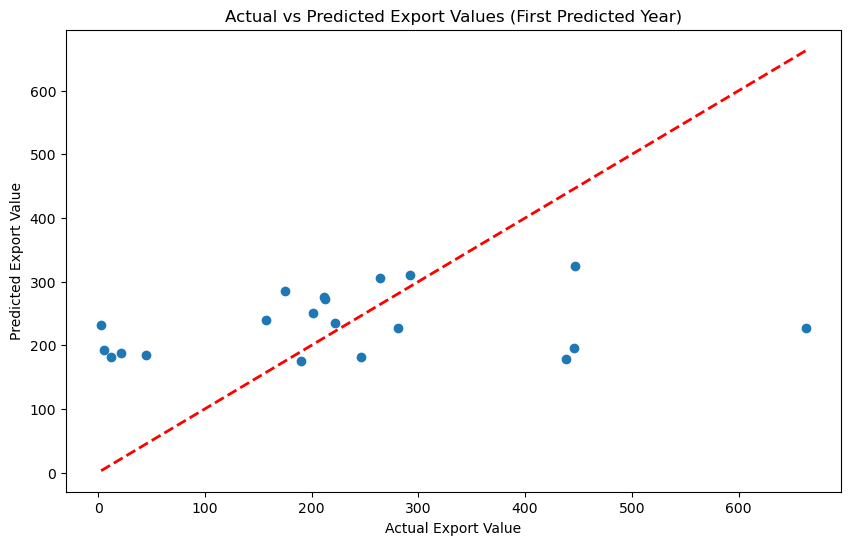


Sample Predictions:
Commodity: WHEAT
Actual: [291.99 274.61]
Predicted: [310.2707  284.48993]
---
Commodity: OTHER CEREALS
Actual: [264.23 288.53]
Predicted: [306.28433 323.83987]
---
Commodity: PULSES
Actual: [446.72 200.98]
Predicted: [324.859   297.58005]
---
Commodity: TOBACCO UNMANUFACTURED
Actual: [211.18 157.66]
Predicted: [276.61755 297.00946]
---
Commodity: TOBACCO MANUFACTURED
Actual: [174.91 212.77]
Predicted: [284.8162  329.12665]
---


In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten
import matplotlib.pyplot as plt

def load_data(file_path):
    df = pd.read_csv(file_path)
    print("Columns in the CSV file:", df.columns.tolist())
    return df

def prepare_data(df):
    year_columns = ['2018-2019', '2019– 2020', '2020– 2021', '2021– 2022', '2022– 2023(P) (Apr.-Sept.)']
    data = df.set_index('Commodity')[year_columns]
    data = data.apply(pd.to_numeric, errors='coerce').dropna()
    return data

def create_sequences(data, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(data) - n_steps_in - n_steps_out + 1):
        X.append(data.iloc[i:i+n_steps_in].values)
        y.append(data.iloc[i+n_steps_in:i+n_steps_in+n_steps_out].values.flatten())  # Flatten target values
    return np.array(X), np.array(y)

def build_model(input_shape, output_shape):
    model = Sequential([
        LSTM(64, activation='relu', input_shape=input_shape, return_sequences=True),
        Dropout(0.2),
        LSTM(32, activation='relu'),
        Dropout(0.2),
        Dense(output_shape)  # Ensure output shape matches y_train
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def main():
    file_path = r"C:\Users\S M VARRSHINI\Desktop\Agriculture Export Products.csv"
    
    # Load and prepare data
    df = load_data(file_path)
    data = prepare_data(df)
    
    print(f"Number of commodities with complete data: {len(data)}")
    
    # Store commodity names for later use
    commodities = data.index.tolist()
    
    # Normalize the data
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)
    
    # Create sequences
    n_steps_in, n_steps_out = 3, 2  # Use 3 years to predict the next 2
    X, y = create_sequences(pd.DataFrame(data_scaled, columns=data.columns, index=data.index), n_steps_in, n_steps_out)
    
    print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")  # Debugging line
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    print(f"Shape of X_train: {X_train.shape}, Shape of X_test: {X_test.shape}")  # Debugging line
    
    # Reshape input to be [samples, time steps, features] for LSTM
    # No need to reshape since we already have (samples, time steps, features)
    
    # Build and train the model
    model = build_model((X_train.shape[1], X_train.shape[2]), y_train.shape[1])
    model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)
    
    # Make predictions
    predictions = model.predict(X_test)
    
    # Inverse transform the predictions and y_test
    predictions_reshaped = predictions.reshape(-1, data.shape[1])
    y_test_reshaped = y_test.reshape(-1, data.shape[1])
    
    predictions_original = scaler.inverse_transform(predictions_reshaped).reshape(-1, n_steps_out)
    y_test_original = scaler.inverse_transform(y_test_reshaped).reshape(-1, n_steps_out)
    
    # Calculate RMSE
    rmse = np.sqrt(np.mean((predictions_original - y_test_original)**2))
    print(f"Root Mean Squared Error: {rmse:.2f}")
    
    # Plot actual vs predicted values for the first predicted year
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test_original[:, 0], predictions_original[:, 0])
    plt.plot([y_test_original[:, 0].min(), y_test_original[:, 0].max()], 
             [y_test_original[:, 0].min(), y_test_original[:, 0].max()], 'r--', lw=2)
    plt.xlabel("Actual Export Value")
    plt.ylabel("Predicted Export Value")
    plt.title("Actual vs Predicted Export Values (First Predicted Year)")
    plt.show()
    
    # Print some sample predictions
    print("\nSample Predictions:")
    for i in range(5):
        actual = y_test_original[i]
        predicted = predictions_original[i]
        print(f"Commodity: {commodities[i]}")
        print(f"Actual: {actual}")
        print(f"Predicted: {predicted}")
        print("---")

if __name__ == "__main__":
    main()